In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import sys
sys.path.append('../')

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import f_classif
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

DATA_PATH = '../data/'
GENERATED_PATH = '../generated/'
GLD_LCIM_STATISTICS_PATH = f'{DATA_PATH}gld_lcim/statistics.npy'

FEATURE_SHORT_LABEL_MAP = {
    'g_means': 'MGB', 
    'diff_g_sums': 'CGB', 
    'cloud_percents': 'CC', 
    'light_percents': 'LP', 
    'flow_sums': 'OFM'
}
FEATURE_LONG_LABEL_MAP = {
    'g_means': 'Mean Global Brightness', 
    'diff_g_sums': 'Change in Global Brightness', 
    'cloud_percents': 'Cloud Coverage', 
    'light_percents': 'Light Percentage', 
    'flow_sums': 'Optical Flow Magnitude'
}
FEATURE_COLOR_MAP = {
    'g_means': 'darkcyan', 
    'diff_g_sums': 'darkcyan', 
    'cloud_percents': 'red', 
    'light_percents': 'red', 
    'flow_sums': 'dimgray'
}

In [7]:
def statistics_to_numpy(statistics):
    # Compute median for each statistic for each scene
    statistics_features = {}
    for key, value in statistics.items():
        statistics_features[key] = {k: np.median(v) for k, v in value.items()}

    # As numpy array
    X = {k: np.array(list(v.values())) for k, v in statistics_features.items()}
    X = np.array(list(X.values()))

    # Normalize
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    return scaler, X, statistics_features.keys()

statistics = np.load(GLD_LCIM_STATISTICS_PATH, allow_pickle=True).item()
scaler, X, labels = statistics_to_numpy(statistics)

part2_statistics = {k: v for k, v in statistics.items() if k.startswith('P2')}
part2_scaler, part2_X, part2_labels = statistics_to_numpy(part2_statistics)

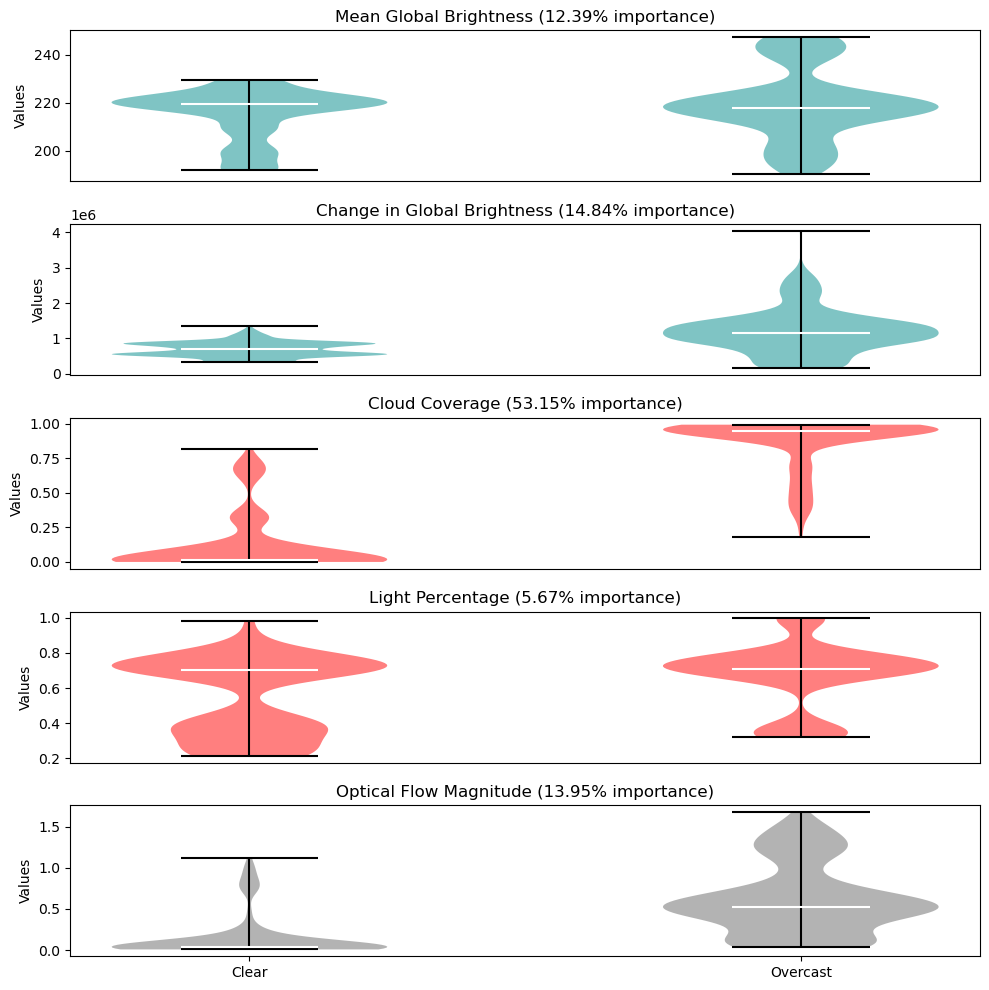

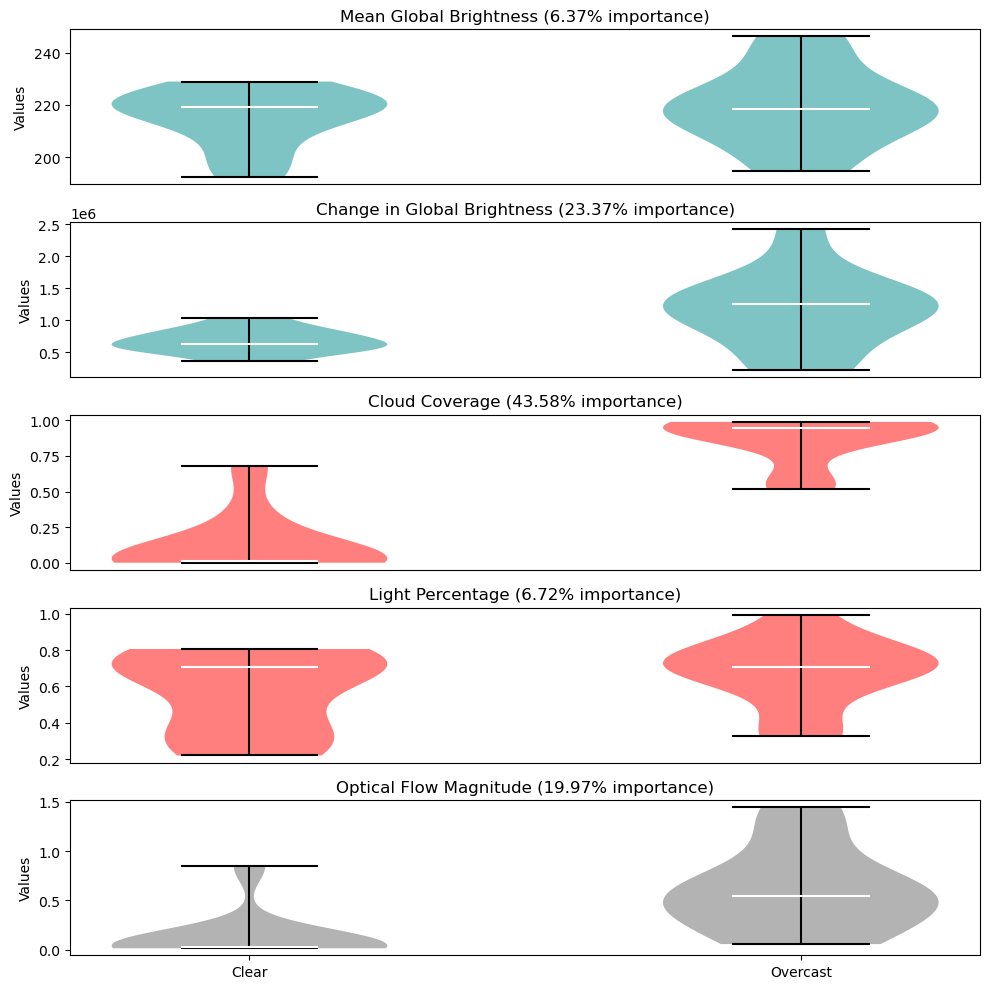

In [8]:
def show_violin(statistics, apply_median=False):
    # Order statistics
    co_statistics = {
        'clear': {},
        'overcast': {}
    }
    for key, features in statistics.items():
        group = 'clear' if 'Clear' in key else 'overcast'
        for feature, values in features.items():
            if feature not in co_statistics[group]:
                co_statistics[group][feature] = []

            if apply_median:
                co_statistics[group][feature].append(np.median(values))
            else:
                co_statistics[group][feature] += values
    plot_data = {feature: [co_statistics['clear'][feature], co_statistics['overcast'][feature]] for feature in FEATURE_LONG_LABEL_MAP.keys()}

    # Get feature importances
    X_features = []
    y_features = []
    for i, (feature, clear_overcast_values) in enumerate(plot_data.items()):
        X_feature = []
        clear_values = clear_overcast_values[0]
        overcast_values = clear_overcast_values[1]
        X_feature += clear_values + overcast_values
        X_features.append(X_feature)

        if i == 0:
            y_features += [0] * len(clear_values) + [1] * len(overcast_values)

    X_feature = np.array(X_features).T
    y_feature = np.array(y_features)

    tree_clf = RandomForestClassifier(n_estimators=100, random_state=0)
    tree_clf.fit(X_feature, y_feature)
    feature_importances = tree_clf.feature_importances_

    # Plot feature distributions
    num_features = len(plot_data)
    plt.figure(figsize=(10, 2 * num_features))

    # Create violin plots for each feature
    for idx, (feature, data) in enumerate(plot_data.items()):
        ax = plt.subplot(num_features, 1, idx + 1)

        # Create violin plot
        parts = ax.violinplot(data, showmeans=False, showmedians=True)

        # Customizing the colors
        for pc in parts['bodies']:
            pc.set_facecolor(FEATURE_COLOR_MAP[feature])
            pc.set_alpha(0.5)
        parts['cmins'].set_color('black')
        parts['cmaxes'].set_color('black')
        parts['cbars'].set_color('black')
        parts['cmedians'].set_color('white')

        # Adding custom x-tick labels
        if idx == num_features - 1:
            ax.set_xticks([1, 2])
            ax.set_xticklabels(['Clear', 'Overcast'])
        else:
            ax.set_xticks([])

        # Setting the title for each subplot
        ax.set_title(f"{FEATURE_LONG_LABEL_MAP[feature]} ({(feature_importances[idx] * 100):.2f}% importance)")

        # Optional: Set y-label
        ax.set_ylabel('Values')

    plt.tight_layout()
    plt.show()

show_violin(part2_statistics)
show_violin(part2_statistics, apply_median=True)

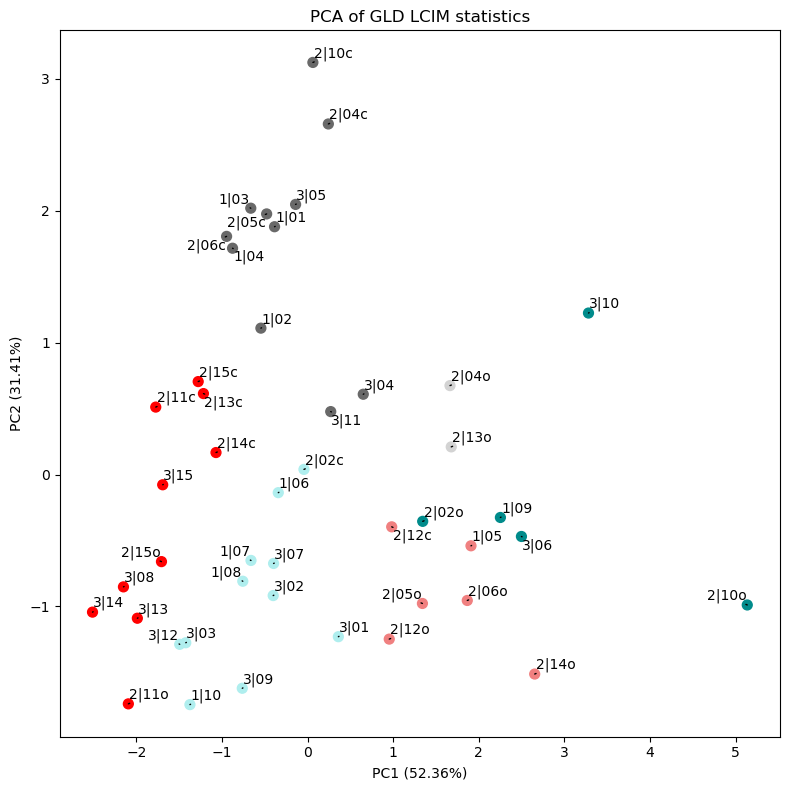

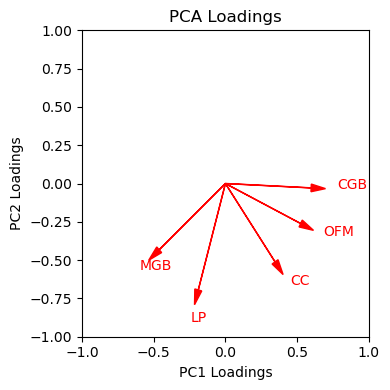

K-means cluster centroids:
Cluster 0 (original): [[2.35173021e+02 4.21268250e+05 1.82193526e-01 8.30160924e-01
  6.86526831e-02]]
Cluster 0 (PCA): [[-1.74759452 -0.34625157]]
Cluster 1 (original): [[1.93610076e+02 1.52812910e+06 9.77426147e-01 6.28249269e-01
  7.48838373e-01]]
Cluster 1 (PCA): [[ 2.90313204 -0.18270998]]
Cluster 2 (original): [[2.09191475e+02 7.34616045e+05 1.33395920e-01 4.27031654e-01
  6.09097549e-02]]
Cluster 2 (PCA): [[-0.25483831  1.76605297]]
Cluster 3 (original): [[2.18247029e+02 1.24163950e+06 7.67024827e-01 7.28581216e-01
  8.12037910e-01]]
Cluster 3 (PCA): [[ 1.61820299 -0.93814721]]
Cluster 4 (original): [[2.30480913e+02 6.29479636e+05 8.21118372e-01 7.81776674e-01
  1.01491557e-01]]
Cluster 4 (PCA): [[-0.66260971 -0.93693209]]
Cluster 5 (original): [[2.17028978e+02 1.29151500e+06 9.45637799e-01 3.42315040e-01
  4.43446645e-01]]
Cluster 5 (PCA): [[1.67149766 0.4423096 ]]


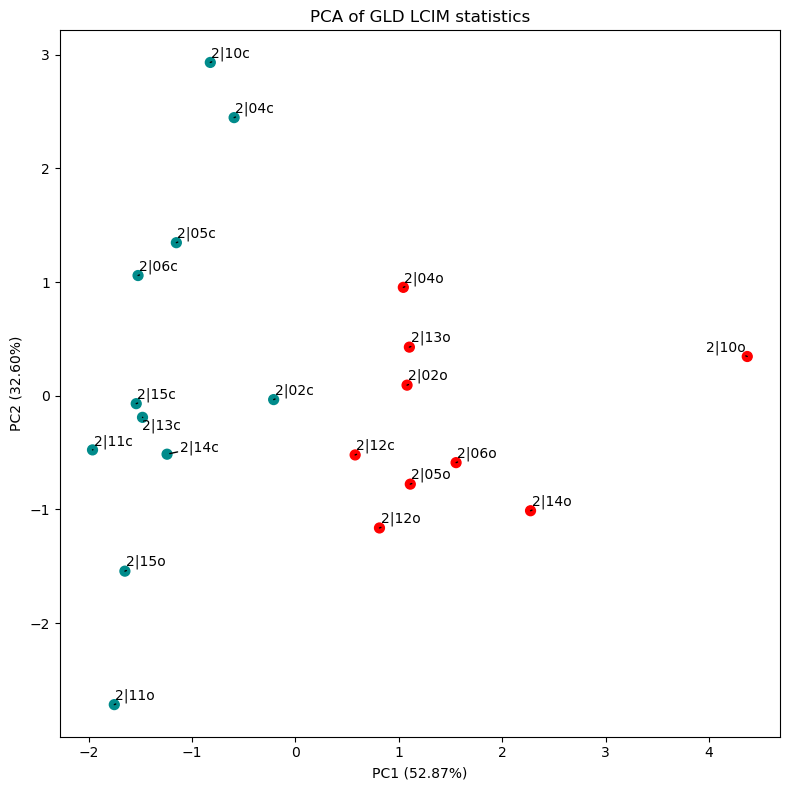

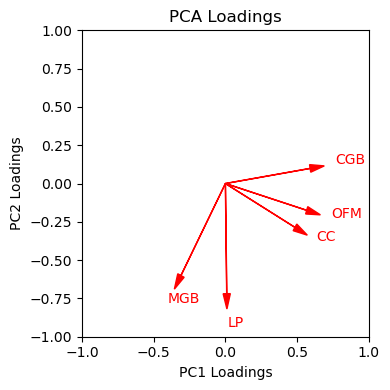

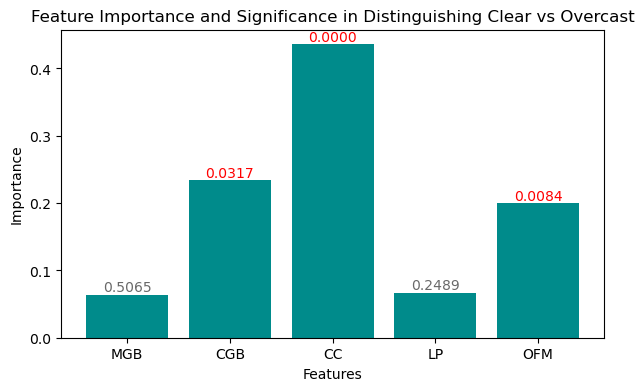

K-means cluster centroids:
Cluster 0 (original): [[2.15871005e+02 1.19137431e+06 8.83086007e-01 6.80554538e-01
  5.79480965e-01]]
Cluster 0 (PCA): [[ 1.54757202 -0.24879208]]
Cluster 1 (original): [[2.23366833e+02 5.15794658e+05 2.35137621e-01 6.47055967e-01
  9.76825594e-03]]
Cluster 1 (PCA): [[-1.26619529  0.20355716]]


In [9]:
def show_PCA(
        X, 
        labels, 
        features, 
        n_clusters, 
        plot_feature_importances = False
    ):
    # Apply PCA
    pca = PCA(n_components=2)
    X_PCA = pca.fit_transform(X)

    # Apply K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto').fit(X)
    cluster_labels = kmeans.labels_

    # Plot PCA
    _, ax1 = plt.subplots(figsize=(8, 8))
    colors = ['red', 'darkcyan', 'dimgray', 'lightcoral', 'paleturquoise', 'lightgray']
    cluster_colors = [colors[label % len(colors)] for label in cluster_labels]

    ax1.scatter(X_PCA[:, 0], X_PCA[:, 1], c=cluster_colors, s=50)

    ls = []
    for i, txt in enumerate(list(labels)):
        label = f"{txt[1]}|{txt.replace('.mp4', '')[-2:]}"
        if 'Clear' in txt:
            label = f"{label}c"
        if 'Overcast' in txt:
            label = f"{label}o"
        ls.append(ax1.annotate(label, (X_PCA[i, 0], X_PCA[i, 1])))

    # Avoid label overlapping
    adjust_text(ls, arrowprops=dict(arrowstyle='-', color='black'))

    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0] * 100:.2f}%)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1] * 100:.2f}%)')
    ax1.set_title('PCA of GLD LCIM statistics')

    plt.tight_layout()
    plt.show()

    # Plot loading
    _, ax2 = plt.subplots(figsize=(4, 4))
    pca_components = pca.components_
    for i, feature in enumerate(features):
        ax2.arrow(0, 0, pca_components[0, i], pca_components[1, i], head_width=0.05, head_length=0.1, fc='red', ec='red', alpha=1.0)
        ax2.text(pca_components[0, i] * 1.3, pca_components[1, i] * 1.3, str(feature), color='red')

    ax2.set_xlim([-1, 1])
    ax2.set_ylim([-1, 1])
    ax2.set_xlabel('PC1 Loadings')
    ax2.set_ylabel('PC2 Loadings')
    ax2.set_title('PCA Loadings')

    # Adjust layout and show the loadings plot figure
    plt.tight_layout()
    plt.show()

    if plot_feature_importances:
        # Plot feature importances
        # Random Forest model
        y = np.array([1 if 'Clear' in l else 0 for l in labels])
        rf = RandomForestClassifier(n_estimators=100, random_state=0)
        rf.fit(X, y)
        importances = rf.feature_importances_

        # ANOVA F-test
        _, p_values = f_classif(X, y)

        plt.figure(figsize=(7, 4))
        bar_colors = ['red' if p < 0.05 else 'dimgray' for p in p_values]
        bars = plt.bar(features, importances, color='darkcyan')

        for i, (bar, p_value) in enumerate(zip(bars, p_values)):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{p_value:.4f}", ha='center', va='bottom', color=bar_colors[i])
        
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.title('Feature Importance and Significance in Distinguishing Clear vs Overcast')
        plt.show()

    # Print k-means cluster centroids
    print('K-means cluster centroids:')
    for i, centroid in enumerate(kmeans.cluster_centers_):
        transformed_centroid = scaler.inverse_transform(centroid.reshape(1, -1))
        pca_centroid = pca.transform(centroid.reshape(1, -1))
        print(f'Cluster {i} (original): {transformed_centroid}')
        print(f'Cluster {i} (PCA): {pca_centroid}')

features = [FEATURE_SHORT_LABEL_MAP[l] for l in statistics[list(statistics.keys())[0]].keys()]
show_PCA(X, labels, features, 6)

part2_features = [FEATURE_SHORT_LABEL_MAP[l] for l in part2_statistics[list(part2_statistics.keys())[0]].keys()]
show_PCA(part2_X, part2_labels, features, 2, plot_feature_importances=True)

In [25]:
def compute_leave_one_out(X, labels, n_clusters):
    loo = LeaveOneOut()
    predictions = []
    true_labels = []

    # Get y labels
    y = np.array([1 if 'Clear' in l else 0 for l in labels])
    
    for train_index, test_index in loo.split(X):
        # Split the data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Apply K-means
        kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
        kmeans.fit(X_train)
        
        # Predict the cluster for the left-out sample
        predicted_cluster = kmeans.predict(X_test)
        
        # Assuming the cluster with the most frequent true label is the correct cluster
        # Find the label that is most common in each cluster
        cluster_labels = np.zeros(n_clusters)
        for i in range(n_clusters):
            # Find indices of points in cluster i
            indices = np.where(kmeans.labels_ == i)
            # Find the most common label in this cluster
            if indices[0].size > 0:
                cluster_labels[i] = np.bincount(y_train[indices]).argmax()
        
        # Append the predicted label for the left-out sample
        predictions.append(cluster_labels[predicted_cluster][0])
        true_labels.append(y_test[0])
    
    # Calculate the accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    # Get the confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print('Confusion matrix:')
    print(cm)

compute_leave_one_out(part2_X, part2_labels, 2)

Accuracy: 85.00%
Confusion matrix:
[[8 2]
 [1 9]]
